# Example 1: Simulated Data

Based on: https://celehs.github.io/PheCAP/articles/example1.html

In [1]:
import sys

sys.path.append('../src')

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from pyphecap.plotting import plot_roc_curves
from pyphecap.predict import predict_phenotype, validate_phenotyping_model
from pyphecap.training import train_phenotyping_model
from pyphecap.feature_extraction import run_feature_extraction
from pyphecap.phecap_data import add_validation_column, Data
from pyphecap.surrogate import Surrogates, Surrogate

In [3]:
np.random.seed(123)

In [4]:
# set variables for below
n_obs = 8000


In [5]:
latent = np.random.gamma(0.3, size=n_obs)
latent2 = np.random.gamma(0.3, size=n_obs)
ehr_data = pd.DataFrame({
    'patient_id': list(range(1, 8001)),
    'ICD1': np.random.poisson(7 * (np.random.gamma(0.2, size=n_obs) + latent) / 0.5),
    'ICD2': np.random.poisson(6 * (np.random.gamma(0.8, size=n_obs) + latent) / 1.1),
    'ICD3': np.random.poisson(1 * (np.random.gamma(0.5 + latent2, size=n_obs)) / 0.5),
    'ICD4': np.random.poisson(2 * (np.random.gamma(0.5, size=n_obs)) / 0.5),
    'NLP1': np.random.poisson(8 * (np.random.gamma(0.2, size=n_obs) + latent) / 0.6),
    'NLP2': np.random.poisson(2 * (np.random.gamma(1.1, size=n_obs) + latent) / 1.5),
    'NLP3': np.random.poisson(5 * (np.random.gamma(0.1, size=n_obs) + latent) / 0.5),
    'NLP4': np.random.poisson(11 * (np.random.gamma(1.9 + latent, size=n_obs)) / 1.9),
    'NLP5': np.random.poisson(3 * (np.random.gamma(0.5 + latent2, size=n_obs)) / 0.5),
    'NLP6': np.random.poisson(2 * (np.random.gamma(0.5, size=n_obs)) / 0.5),
    'NLP7': np.random.poisson(1 * (np.random.gamma(0.5, size=n_obs)) / 0.5),
    'HU': np.random.poisson(30 * (np.random.gamma(0.1, size=n_obs)) / 0.1),
    'label': np.nan,
})
sample_idx = ehr_data.sample(n=400).index
ehr_data.loc[sample_idx, 'label'] = ehr_data.iloc[sample_idx].apply(
    lambda r: np.random.binomial(1, sp.stats.logistic.cdf(
        -5 + 1.5 * np.log1p(r['ICD1']) + np.log1p(r['NLP1'])
        + 0.8 * np.log1p(r['NLP3']) - 0.5 * np.log1p(r['HU'])
    )),
    axis=1
)
ehr_data.head()

,patient_id,ICD1,ICD2,ICD3,ICD4,NLP1,NLP2,NLP3,NLP4,NLP5,NLP6,NLP7,HU,label
0,1,2,6,1,1,2,3,4,6,3,4,0,2,NaN
1,2,6,0,2,0,2,0,4,36,0,0,0,0,NaN
2,3,3,4,2,0,28,0,4,9,2,1,0,0,NaN
3,4,3,12,3,0,2,2,0,0,57,2,1,0,NaN
4,5,1,1,2,1,0,3,0,8,2,0,2,16,NaN


In [6]:
ehr_data['label'].value_counts()

0.0    252
1.0    148
Name: label, dtype: int64

Define the features and labels used for phenotyping

In [7]:
add_validation_column(ehr_data)
data = Data(
    ehr_data,
    'HU',
    'label',
    'validation',
)

In [8]:
data.training_set['label'].value_counts()

0.0    147
1.0     94
Name: label, dtype: int64

In [9]:
data.validation_set['label'].value_counts()

0.0    105
1.0     54
Name: label, dtype: int64

Specify the surrogates to be used for the surrogate-assisted feature extraction (SAFE).

Typically:
* primary ICD code
* primary NLP CUI
* both together

In [10]:
surrogates = Surrogates(
    Surrogate('ICD1'),
    Surrogate('NLP1'),
    # Surrogate('ICD1', 'NLP1'),  # together not used in R example
)

In [11]:
%%timeit -n 1 -r 1
run_feature_extraction(data, surrogates)

1.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
selected_features = run_feature_extraction(data, surrogates)
selected_features


['ICD1', 'NLP1', 'ICD2', 'NLP2', 'NLP3', 'NLP4', 'NLP5', 'NLP6']

In [13]:
coefficients, train_roc_auc, split_roc_auc = train_phenotyping_model(data, surrogates, selected_features)
coefficients, train_roc_auc[0], split_roc_auc[0]

([('intercept', -0.13046640486676414),
  ('ICD1', 0.24601472113063863),
  ('NLP1', 0.12460497678109601),
  ('HU', -0.018325836213148712),
  ('NLP3', 0.13498185303684967),
  ('NLP2', 0.030034356847232033),
  ('NLP4', 0.018188596869293493),
  ('NLP6', 0.016074688285813696),
  ('ICD2', -0.020611331716419254),
  ('NLP5', -0.03711999675291455)],
 0.9712693588073528,
 0.9642857142857142)

In [14]:
valid_roc_auc = validate_phenotyping_model(data, surrogates, coefficients, selected_features)
valid_roc_auc[0]

0.9444444444444444

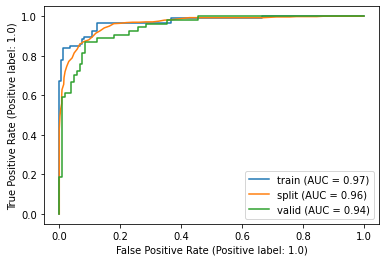

In [15]:
plot_roc_curves(train_roc_auc, split_roc_auc, valid_roc_auc)
plt.show()

Apply the model

In [16]:
phenotype = predict_phenotype(data, surrogates, coefficients, selected_features, valid_roc=valid_roc_auc[1])
phenotype.head()


,patient_id,prediction,case_status
0,1,0.376951,0
1,2,0.621641,1
2,3,0.597681,1
3,4,0.073845,0
4,5,-0.023683,0
